Governance and Traceability Simulation

This models the audit traceability and artifact management efficiency with and without ACDOF.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# For reproducibility
rng = np.random.default_rng(42)

# Global matplotlib style (optional)
plt.rcParams['figure.figsize'] = (7, 5)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.2

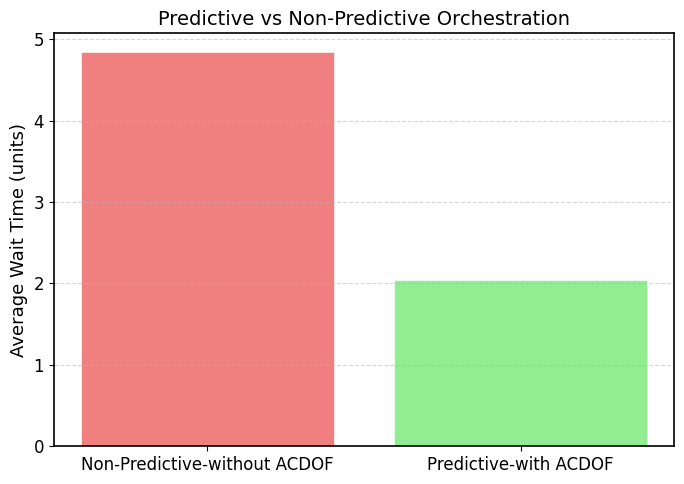

Average wait time (Non-Predictive): 4.83 units
Average wait time (Predictive): 2.03 units


In [ ]:
# -----------------------------
# FIGURE 2: Predictive vs Non-Predictive
# -----------------------------
n_jobs = 1000

# Non-predictive: higher, spiky wait times
non_pred_wait = rng.normal(loc=4.5, scale=1.0, size=n_jobs)
non_pred_wait = np.clip(non_pred_wait, 0.5, None)
# Add spikes for every 10th job (burst traffic)
spike_indices = np.arange(0, n_jobs, 10)
non_pred_wait[spike_indices] += rng.normal(loc=3.5, scale=0.8, size=len(spike_indices))

# Predictive: lower, smoother wait times
pred_wait = rng.normal(loc=2.0, scale=0.5, size=n_jobs)
pred_wait = np.clip(pred_wait, 0.2, None)

avg_non_pred = non_pred_wait.mean()
avg_pred = pred_wait.mean()

# Bar chart
labels = ['Non-Predictive-without ACDOF', 'Predictive-with ACDOF']
values = [avg_non_pred, avg_pred]

plt.figure()
bars = plt.bar(labels, values)
bars[0].set_color('lightcoral')   # red-ish
bars[1].set_color('lightgreen')   # green-ish

plt.ylabel('Average Wait Time (units)', fontsize=13)
plt.title('Predictive vs Non-Predictive Orchestration', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("fig2_predictive_vs_nonpredictive.png", dpi=600, bbox_inches='tight')
plt.show()

print(f"Average wait time (Non-Predictive): {avg_non_pred:.2f} units")
print(f"Average wait time (Predictive): {avg_pred:.2f} units")


Total CO2 Greedy: 523622.14 g
Total CO2 Energy-Aware: 218175.89 g
Total Cost Greedy: $87.27
Total Cost Energy-Aware: $130.91
CO2 reduction: 58.33%
Cost reduction: -50.00%


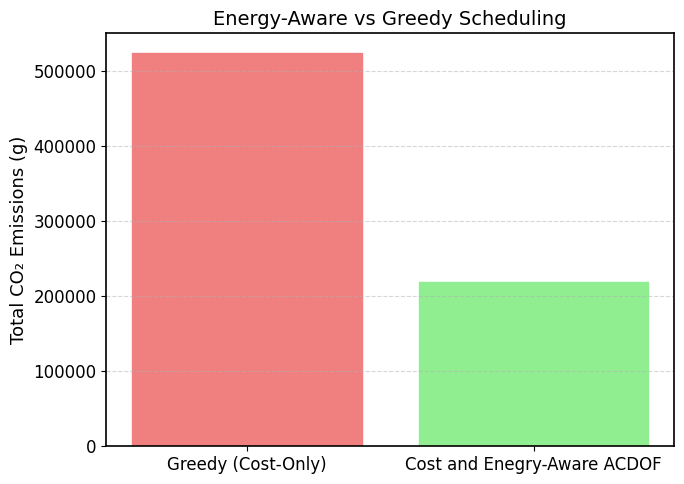

In [ ]:
# -----------------------------
# FIGURE 3: Energy-Aware vs Greedy Scheduling
# -----------------------------
regions = {
    "US-West": {"ci": 400, "price": 0.12},  # gCO2/kWh, $/kWh
    "EU-Central": {"ci": 250, "price": 0.15},
    "Asia-East": {"ci": 600, "price": 0.10},
}

n_jobs_energy = 500
energy_per_job = rng.uniform(0.5, 3.0, size=n_jobs_energy)

# Greedy: chooses lowest cost region (Asia-East)
greedy_region = "Asia-East"
greedy_ci = regions[greedy_region]["ci"]
greedy_price = regions[greedy_region]["price"]

greedy_total_co2 = np.sum(energy_per_job * greedy_ci)
greedy_total_cost = np.sum(energy_per_job * greedy_price)

# Energy-aware: choose region by weighted score of carbon + price
alpha = 1.0   # weight for carbon intensity
beta = 200.0  # weight for price (scaled so both matter)

energy_aware_co2 = 0.0
energy_aware_cost = 0.0

for e in energy_per_job:
    best_region = None
    best_score = float("inf")
    for name, info in regions.items():
        score = alpha * info["ci"] + beta * info["price"]
        if score < best_score:
            best_score = score
            best_region = name
    energy_aware_co2 += e * regions[best_region]["ci"]
    energy_aware_cost += e * regions[best_region]["price"]

print(f"Total CO2 Greedy: {greedy_total_co2:.2f} g")
print(f"Total CO2 Energy-Aware: {energy_aware_co2:.2f} g")
print(f"Total Cost Greedy: ${greedy_total_cost:.2f}")
print(f"Total Cost Energy-Aware: ${energy_aware_cost:.2f}")
print(f"CO2 reduction: {(greedy_total_co2 - energy_aware_co2) / greedy_total_co2 * 100:.2f}%")
print(f"Cost reduction: {(greedy_total_cost - energy_aware_cost) / greedy_total_cost * 100:.2f}%")

# Bar chart for CO2 emissions
labels = ['Greedy (Cost-Only)', 'Cost and Enegry-Aware ACDOF']
values = [greedy_total_co2, energy_aware_co2]

plt.figure()
bars = plt.bar(labels, values)
bars[0].set_color('lightcoral')
bars[1].set_color('lightgreen')

plt.ylabel('Total CO₂ Emissions (g)', fontsize=13)
plt.title('Energy-Aware vs Greedy Scheduling', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("fig3_energy_aware_vs_greedy.png", dpi=600, bbox_inches='tight')
plt.show()


Adaptive Failover Events: 0
Average Latency (Static): 132.80 ms
Average Latency (Adaptive): 96.29 ms


/tmp/ipython-input-1937430510.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(


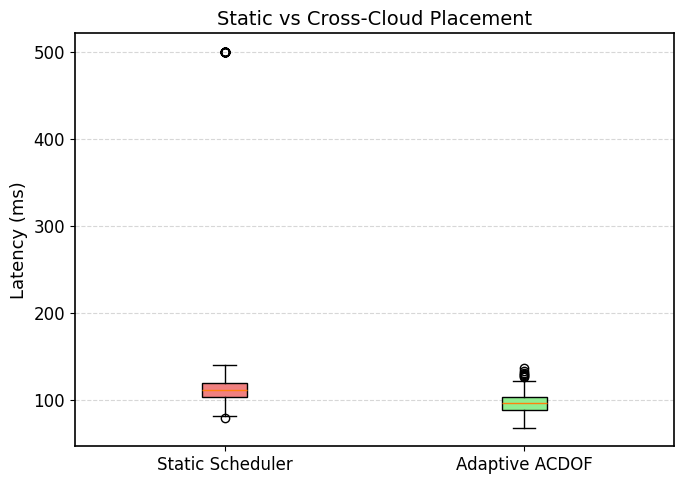

In [ ]:
# -----------------------------
# FIGURE 4: Static vs Cross-Cloud Placement
# -----------------------------
clouds_latency = {
    "AWS": {"avg_latency": 110, "fail_rate": 0.05},
    "Azure": {"avg_latency": 130, "fail_rate": 0.02},
    "GCP": {"avg_latency": 95, "fail_rate": 0.07},
}

n_jobs_latency = 500
static_latencies = []
adaptive_latencies = []
failover_events = 0

for _ in range(n_jobs_latency):
    # --- Static: always AWS ---
    if rng.random() < clouds_latency["AWS"]["fail_rate"]:
        static_latencies.append(500.0)  # failure penalty
    else:
        static_latencies.append(
            rng.normal(clouds_latency["AWS"]["avg_latency"], 10.0)
        )

    # --- Adaptive: try lowest-latency clouds first ---
    sorted_clouds = sorted(clouds_latency.items(), key=lambda x: x[1]["avg_latency"])
    rerouted = False

    for provider, info in sorted_clouds:
        if rng.random() > info["fail_rate"]:
            adaptive_latencies.append(
                rng.normal(info["avg_latency"], 10.0)
            )
            rerouted = True
            break

    if not rerouted:
        adaptive_latencies.append(500.0)
        failover_events += 1

static_latencies = np.array(static_latencies)
adaptive_latencies = np.array(adaptive_latencies)

print("Adaptive Failover Events:", failover_events)
print(f"Average Latency (Static): {static_latencies.mean():.2f} ms")
print(f"Average Latency (Adaptive): {adaptive_latencies.mean():.2f} ms")

plt.figure()
box = plt.boxplot(
    [static_latencies, adaptive_latencies],
    labels=["Static Scheduler", "Adaptive ACDOF"],
    patch_artist=True
)

colors = ['lightcoral', 'lightgreen']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.ylabel("Latency (ms)", fontsize=13)
plt.title("Static vs Cross-Cloud Placement", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("fig4_static_vs_crosscloud.png", dpi=600, bbox_inches='tight')
plt.show()


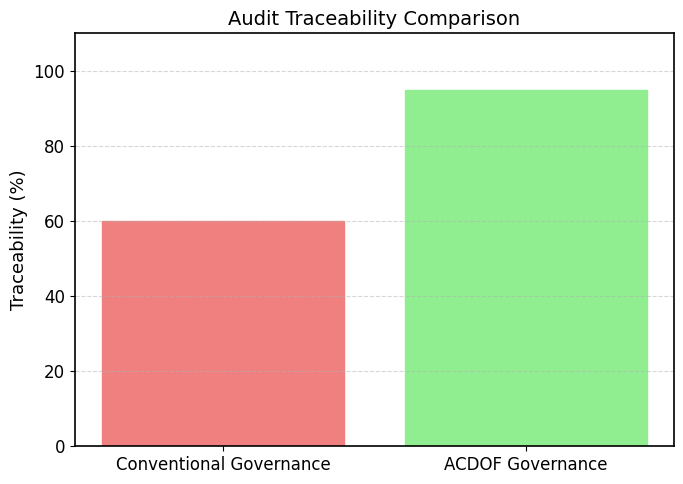

In [ ]:
# -----------------------------
# FIGURE 5: Traceability Comparison
# -----------------------------
baseline_trace = 60
acdof_trace = 95

labels = ['Conventional Governance', 'ACDOF Governance']
values = [baseline_trace, acdof_trace]

plt.figure()
bars = plt.bar(labels, values)
bars[0].set_color('lightcoral')
bars[1].set_color('lightgreen')

plt.ylabel('Traceability (%)', fontsize=13)
plt.title('Audit Traceability Comparison', fontsize=14)
plt.ylim(0, 110)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("fig5_traceability_comparison.png", dpi=600, bbox_inches='tight')
plt.show()


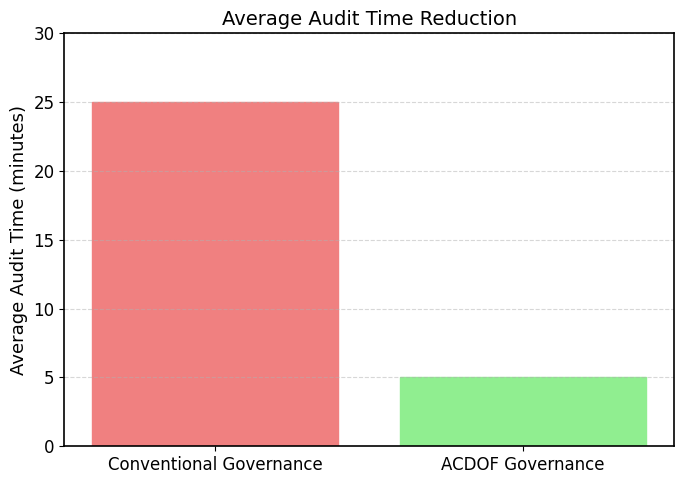

In [ ]:
# -----------------------------
# FIGURE 6: Average Audit Time Comparison
# -----------------------------
baseline_audit = 25
acdof_audit = 5

labels = ['Conventional Governance', 'ACDOF Governance']
values = [baseline_audit, acdof_audit]

plt.figure()
bars = plt.bar(labels, values)
bars[0].set_color('lightcoral')
bars[1].set_color('lightgreen')

plt.ylabel('Average Audit Time (minutes)', fontsize=13)
plt.title('Average Audit Time Reduction', fontsize=14)
plt.ylim(0, 30)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("fig6_audit_time_comparison.png", dpi=600, bbox_inches='tight')
plt.show()
